# <center>[미니프로젝트] 트럼프 대통령 트윗 분석</center>  

# 1. 분석 준비

## 1.1 라이브러리 불러오기

In [34]:
# 분석 라이브러리 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 경고 문구 미표시
import warnings
warnings.filterwarnings(action='ignore')

## 1.2 데이터 불러오기 

* 캐글(www.kaggle.com)은 인공지능과 데이터 분석에 관심이 있는 전세계 분석가들이 모여서 활동하는 대표적인 커뮤니티입니다. 
* 캐글에 등록되어 있는 공개 데이터셋을 활용하여, 트럼프 대통령의 트윗 내용을 분석합니다.  

출처: https://www.kaggle.com/datasets/austinreese/trump-tweets

In [35]:
# 캐글에 가입하고, [Data] 탭에서 데이터 내용과 파일 목록을 확인합니다.  
# [Download] 버튼을 클릭하여 데이터를 다운로드합니다.
# 다운로드한 zip 압축파일을 해제하고, CSV파일(trumptweets.csv)을 data 폴더로 이동합니다. 

# CSV 파일을 판다스 read_csv 함수로 읽어와서, 데이터프레임 형식으로 변환합니다. 
data = pd.read_csv('./data/trumptweets.csv')

# 데이터프레임의 첫 2행을 출력합니다. 
data.head(2)

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,NaN,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273,NaN,NaN,NaN


In [36]:
# 기본 정보
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41122 entries, 0 to 41121
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         41122 non-null  int64  
 1   link       41122 non-null  object 
 2   content    41122 non-null  object 
 3   date       41122 non-null  object 
 4   retweets   41122 non-null  int64  
 5   favorites  41122 non-null  int64  
 6   mentions   22467 non-null  object 
 7   hashtags   5810 non-null   object 
 8   geo        0 non-null      float64
dtypes: float64(1), int64(3), object(5)
memory usage: 2.8+ MB


In [37]:
# 결측값 확인
data.isnull().sum()

id               0
link             0
content          0
date             0
retweets         0
favorites        0
mentions     18655
hashtags     35312
geo          41122
dtype: int64

3개의 컬럼('mentions', 'hashtags', 'geo')에 결측값이 상당한 비율로 포함되어 있습니다. 

In [38]:
# 중복데이터 확인
data.duplicated().sum()

0

같은 행이 중복으로 존재하지 않습니다. 

# 2. 프로젝트 수행하기

## 2.1 데이터 정제

### 2.1.1 결측값이 있는 변수를 찾아서 data 데이터프레임에서 삭제합니다. 

In [39]:
# columns 속성으로, 변수(컬럼)들의 이름을 확인할 수 있습니다. 
data.columns

Index(['id', 'link', 'content', 'date', 'retweets', 'favorites', 'mentions',
       'hashtags', 'geo'],
      dtype='object')

In [40]:
# dropna 함수를 이용하여 결측이 1개 이상이면(how='any'), 해당 변수(컬럼)를 제거합니다.
data = data.dropna(how='any', axis=1)

# 잘 제거되었는지 확인합니다.
print(data.columns)

Index(['id', 'link', 'content', 'date', 'retweets', 'favorites'], dtype='object')


결측값이 있는 3개의 컬럼('mentions', 'hashtags', 'geo')이 데이터프레임에서 제거된 것을 알 수 있습니다.

### 2.1.2 분석에 적합한 형태로 데이터프레임을 정리합니다. 
1) 분석에 사용하지 않을 id, link 컬럼을 제외합니다. 
2) 트윗이 게시된 시각을 나타내는 date 컬럼을 첫 번째 순서로 이동합니다. (date, content, retweets, favorites 순서)
3) 문자열 함수를 이용하여, date 컬럼에서 연도, 월을 추출하여 각각 새로운 컬럼으로 추가합니다.

#### 1) 분석에 사용하지 않을 id, link 컬럼을 제외합니다. 

In [41]:
# loc 인덱서를 사용하여 'content' 컬럼부터 슬라이싱 기법으로 선택합니다.
df_cleaned = data.loc[:, 'content':]

# 첫 5행을 출력합니다. 
df_cleaned.head()

,content,date,retweets,favorites
0,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868
1,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273
2,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18
3,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24
4,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965


#### 2) 트윗이 게시된 시각을 나타내는 date 컬럼을 첫 번째 순서로 이동합니다. (date, content, retweets, favorites 순서)

In [42]:
# 변경을 원하는 순서대로 컬럼의 배열을 정리합니다.
new_col_order = ['date', 'content', 'retweets', 'favorites']

# 새로운 컬럼의 배열을 이용하여 데이터프레임을 새롭게 구성합니다.
df_cleaned = df_cleaned[new_col_order]

# 첫 5행을 출력합니다. 
df_cleaned.head()

,date,content,retweets,favorites
0,2009-05-04 20:54:25,Be sure to tune in and watch Donald Trump on L...,500,868
1,2009-05-05 03:00:10,Donald Trump will be appearing on The View tom...,33,273
2,2009-05-08 15:38:08,Donald Trump reads Top Ten Financial Tips on L...,12,18
3,2009-05-08 22:40:15,New Blog Post: Celebrity Apprentice Finale and...,11,24
4,2009-05-12 16:07:28,"""My persona will never be that of a wallflower...",1399,1965


#### 3) 문자열 함수를 이용하여, date 컬럼에서 연도, 월을 추출하여 각각 새로운 컬럼으로 추가합니다.

In [43]:
# date 컬럼의 첫 번째 데이터를 dt_sample 변수에 저장합니다. 
# 첫 번째 행의 데이터를 샘플로 추출하여 먼저 작업하고, 동일한 방식으로 다른 행의 데이터로 확장하여 적용합니다. 
dt_sample = df_cleaned['date'][0]
dt_sample

'2009-05-04 20:54:25'

In [44]:
# 공백(띄어쓰기 한칸)을 기준으로 문자열을 분할하면, 날짜와 시간으로 구분할 수 있습니다.
dt_sample.split(' ')

['2009-05-04', '20:54:25']

In [45]:
# 날짜 부분을 인덱싱하여 첫 번째 원소를 선택하고, '-' 기호를 기준으로 다시 한번 분할합니다. 
_date = dt_sample.split(' ')[0]
print(_date)

_date_items = _date.split('-')
print(_date_items)

2009-05-04
['2009', '05', '04']


In [46]:
# _date_items 리스트에서 첫번째 원소가 연도를 나타내고, 두번째 원소가 월을 나타냅니다. (2009년 5월)
_year = _date_items[0]
_month = _date_items[1]

print(f"첫 번째 트윗은 {_year}년 {_month}월에 게시되었습니다.")

첫 번째 트윗은 2009년 05월에 게시되었습니다.


In [47]:
# 다른 행의 데이터에 대해서도 for 반복문을 적용하여 연도를 year 리스트에 추출하고, 월을 month 리스트에 추출하여 정리합니다. 
year = []
month = []

for dt_sample in df_cleaned['date']:
    
    # 위에서 샘플 데이터를 활용하여 처리한 코드를 활용
    _date = dt_sample.split(' ')[0]
    _date_items = _date.split('-')
    _year = _date_items[0]
    _month = _date_items[1]
    
    # 추출한 데이터를 각각 year, month 리스트에 추가(append)
    year.append(_year)
    month.append(_month)

# 추출된 원소의 갯수를 확인합니다.     
print(len(year), len(month))

41122 41122


In [48]:
# 추출된 year, month 리스트의 데이터를 각각 새로운 컬럼으로 추가합니다. 
df_cleaned['year'] = year
df_cleaned['month'] = month

# 첫 5행을 출력합니다. 
df_cleaned.head()

,date,content,retweets,favorites,year,month
0,2009-05-04 20:54:25,Be sure to tune in and watch Donald Trump on L...,500,868,2009,05
1,2009-05-05 03:00:10,Donald Trump will be appearing on The View tom...,33,273,2009,05
2,2009-05-08 15:38:08,Donald Trump reads Top Ten Financial Tips on L...,12,18,2009,05
3,2009-05-08 22:40:15,New Blog Post: Celebrity Apprentice Finale and...,11,24,2009,05
4,2009-05-12 16:07:28,"""My persona will never be that of a wallflower...",1399,1965,2009,05


## 2.2 연도별 트윗량 분석  
1) year 변수를 구성하는 데이터의 도수(frequency)를 확인합니다.
2) 연도별 빈도수 데이터를 판다스 시리즈 객체의 인덱스(연도) 순으로 오름차순 정렬합니다.
3) 판다스 plot 함수를 이용하여 연도별 트윗량을 그래프로 시각화합니다. 

### 1) year 변수를 구성하는 데이터의 도수(frequency)를 확인합니다.

In [49]:
# value_counts 함수
df_cleaned['year'].value_counts()

2013    8207
2015    7719
2014    5987
2019    4588
2012    4190
2016    3951
2018    2998
2017    2232
2011     870
2020     181
2010     143
2009      56
Name: year, dtype: int64

2013년에 트윗량이 가장 많고, 트윗을 처음 시작한 2009년의 트윗량이 가장 적은 편입니다.

### 2) 연도별 빈도수 데이터를 판다스 시리즈 객체의 인덱스(연도) 순으로 오름차순 정렬합니다.

In [50]:
# sort_index 함수를 사용하고, 오름차순 정렬합니다. (ascending=True)
df_cleaned['year'].value_counts().sort_index()

2009      56
2010     143
2011     870
2012    4190
2013    8207
2014    5987
2015    7719
2016    3951
2017    2232
2018    2998
2019    4588
2020     181
Name: year, dtype: int64

### 3) 판다스 plot 함수를 이용하여 연도별 트윗량을 그래프로 시각화합니다. 

<AxesSubplot: >

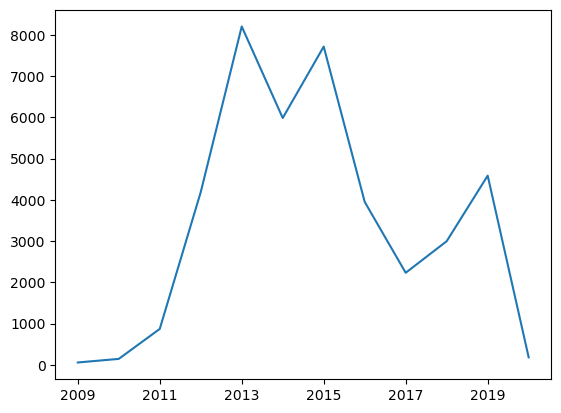

In [51]:
# plot 함수는 기본값으로 선 그래프를 출력합니다. (kind='line')
df_cleaned['year'].value_counts().sort_index().plot()

<AxesSubplot: >

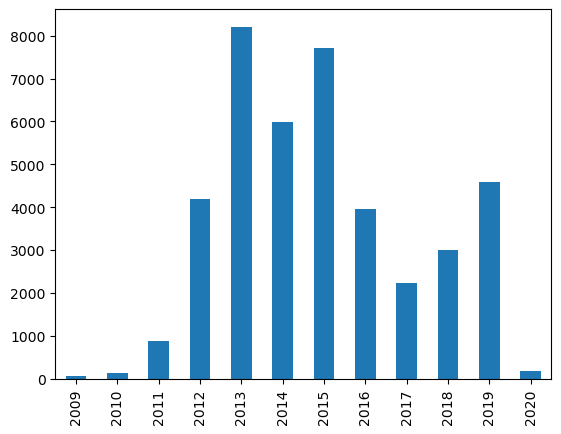

In [52]:
# plot 함수의 옵션을 적용하여 막대 그래프를 출력합니다. (kind='bar')
df_cleaned['year'].value_counts().sort_index().plot(kind='bar')

<AxesSubplot: ylabel='year'>

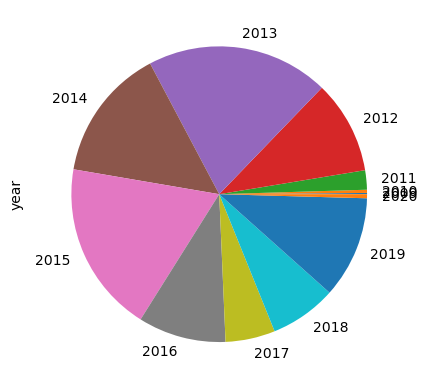

In [53]:
# plot 함수의 옵션을 적용하여 원 그래프(Pie Chart)를 출력합니다. (kind='pie')
df_cleaned['year'].value_counts().sort_index().plot(kind='pie')

## 2.3 트윗 반응 분석
1) Retweet 갯수가 많은 순서대로 5개의 트윗을 추출합니다.
2) 좋아요(favorites) 갯수가 많은 순서대로 상위 1%안에 해당하는 트윗을 모두 추출합니다.

### 1) Retweet 갯수가 많은 순서대로 5개의 트윗을 추출합니다.

In [54]:
# sort_value 함수를 사용하여 retweets 변수의 데이터 크기 순으로 정렬합니다. 이때, 내림차순으로 정렬합니다. (ascending=False)
df_cleaned.sort_values(by='retweets', ascending=False)

,date,content,retweets,favorites,year,month
32059,2017-07-02 15:21:42,# FraudNewsCNN # FNNpic.twitter.com/WYUnHjjUjg,309892,528265,2017,07
30895,2016-11-08 12:43:14,TODAY WE MAKE AMERICA GREAT AGAIN!,295817,518347,2016,11
15535,2014-06-04 12:23:11,Are you allowed to impeach a president for gro...,246232,237843,2014,06
38625,2019-08-02 19:41:30,A$AP Rocky released from prison and on his way...,240363,857678,2019,08
33061,2017-11-12 01:48:01,Why would Kim Jong-un insult me by calling me ...,229531,559317,2017,11
...,...,...,...,...,...,...
10747,2013-08-01 12:36:26,@ ccalder0811 Thank you.,0,0,2013,08
8531,2013-04-24 10:49:24,@ RamboFo Great!,0,1,2013,04
6291,2013-02-07 21:29:42,@ bahia6085 Thanks Suz for your comments.,0,0,2013,02
10794,2013-08-02 15:24:36,@ not_that_actor I know!,0,0,2013,08


In [55]:
# 정렬 순으로 상위 5행의 데이터를 추출합니다.
top5_retweets = df_cleaned.sort_values(by='retweets', ascending=False).iloc[:5]
top5_retweets

,date,content,retweets,favorites,year,month
32059,2017-07-02 15:21:42,# FraudNewsCNN # FNNpic.twitter.com/WYUnHjjUjg,309892,528265,2017,07
30895,2016-11-08 12:43:14,TODAY WE MAKE AMERICA GREAT AGAIN!,295817,518347,2016,11
15535,2014-06-04 12:23:11,Are you allowed to impeach a president for gro...,246232,237843,2014,06
38625,2019-08-02 19:41:30,A$AP Rocky released from prison and on his way...,240363,857678,2019,08
33061,2017-11-12 01:48:01,Why would Kim Jong-un insult me by calling me ...,229531,559317,2017,11


### 2) 좋아요(favorites) 갯수가 많은 순서대로 상위 1%안에 해당하는 트윗을 모두 추출합니다.

In [56]:
# sort_value 함수를 사용하여 favorites 변수의 데이터 크기 순으로 정렬합니다. 이때, 내림차순으로 정렬합니다. (ascending=False)
top_1_percent_favorites = df_cleaned.sort_values(by='favorites', ascending=False)
top_1_percent_favorites

,date,content,retweets,favorites,year,month
38625,2019-08-02 19:41:30,A$AP Rocky released from prison and on his way...,240363,857678,2019,08
40959,2020-01-03 03:32:53,pic.twitter.com/VXeKiVzpTf,171742,812508,2020,01
40990,2020-01-08 03:45:24,All is well! Missiles launched from Iran at tw...,158748,766263,2020,01
40868,2019-12-25 13:26:31,MERRY CHRISTMAS!,114052,738868,2019,12
38394,2019-07-19 22:01:47,Just spoke to @ KanyeWest about his friend A$A...,195109,717895,2019,07
...,...,...,...,...,...,...
5591,2013-01-11 21:31:49,@ NormaWilcox Thank you.,0,0,2013,01
6180,2013-02-05 22:42:19,@ festenoc True and thanks.,2,0,2013,02
3552,2012-10-03 21:25:31,@ SiphoSimelane Thank you.,3,0,2012,10
9960,2013-06-27 18:14:20,@ MIbrunette Our country needs the same fix-up.,2,0,2013,06


In [57]:
# 상위 1%에 해당하는 인덱스 값을 계산합니다. 
top_1_percent_index = int(len(top_1_percent_favorites) * 0.01)
top_1_percent_index

411

In [58]:
# 상위 1% 경계에 해당하는 인덱스까지 슬라이싱으로 추출합니다. (iloc)
top_1_percent_favorites = top_1_percent_favorites.iloc[:top_1_percent_index]
top_1_percent_favorites

,date,content,retweets,favorites,year,month
38625,2019-08-02 19:41:30,A$AP Rocky released from prison and on his way...,240363,857678,2019,08
40959,2020-01-03 03:32:53,pic.twitter.com/VXeKiVzpTf,171742,812508,2020,01
40990,2020-01-08 03:45:24,All is well! Missiles launched from Iran at tw...,158748,766263,2020,01
40868,2019-12-25 13:26:31,MERRY CHRISTMAS!,114052,738868,2019,12
38394,2019-07-19 22:01:47,Just spoke to @ KanyeWest about his friend A$A...,195109,717895,2019,07
...,...,...,...,...,...,...
40844,2019-12-21 22:07:01,pic.twitter.com/h5bAKuoyV2,44150,159556,2019,12
38397,2019-07-20 15:52:30,Just had a very good call with @ SwedishPM Ste...,29517,159502,2019,07
32623,2017-09-24 12:44:52,If NFL fans refuse to go to games until player...,37803,159480,2017,09
36316,2018-12-27 12:59:04,Just returned from visiting our troops in Iraq...,26243,159097,2018,12


## 2.4 Word Cloud 시각화
1) 좋아요(favorites) 갯수가 많은 순서대로 상위 1%안에 해당하는 트윗을 대상으로 시각화합니다. 
2) 트윗에는 물음표(?), 느낌표(!) 등 특수문자들이 포함되어 있습니다. 먼저, 각 트윗에 포함되어 있는 특수문자를 제거합니다. 
3) 특수문자가 제거된 트윗들을 하나의 문자열로 결합합니다. 
4) WordCloud 시각화를 처리하고 화면에 출력합니다. 

### 1) 좋아요(favorites) 갯수가 많은 순서대로 상위 1%안에 해당하는 트윗을 대상으로 시각화합니다. 

In [59]:
# top_1_percent_favorites 데이터프레임에서 content 변수를 선택합니다. 
tweets = top_1_percent_favorites['content'].to_list()
print(f"트윗 갯수: {len(tweets)}")

트윗 갯수: 411


In [60]:
# 첫 번째 트윗을 화면에 출력해봅니다.
print(tweets[0])

A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!


### 2) 트윗에는 물음표(?), 느낌표(!) 등 특수문자들이 포함되어 있습니다. 먼저, 각 트윗에 포함되어 있는 특수문자를 제거합니다. 

In [61]:
# string 라이브러리에서 특수문자(punctuation)를 가져옵니다.  
from string import punctuation
print(f"특수문자: {punctuation}")

# punctuation에 들어있는 각각의 특수문자를 찾아서 제거합니다. 
sample_text = tweets[0]

for char in punctuation:
    sample_text = sample_text.replace(char, '')
    
print(f"특수문자 제거 후: {sample_text}")

특수문자: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
특수문자 제거 후: AAP Rocky released from prison and on his way home to the United States from Sweden It was a Rocky Week get home ASAP AAP


In [62]:
# tweets 변수에 저장되어 있는 모든 트윗에 대해서도 특수문자를 찾아서 제거합니다. 
print(f"인덱스가 10인 트윗(처리 전): {tweets[10]}")

for i in range(len(tweets)):
    
    # punctuation에 들어있는 특수문자를 제거
    for char in punctuation:
        tweets[i] = tweets[i].replace(char, '')    
        
print(f"인덱스가 10인 트윗(처리 후): {tweets[10]}")

인덱스가 10인 트윗(처리 전): Why would Kim Jong-un insult me by calling me "old," when I would NEVER call him "short and fat?" Oh well, I try so hard to be his friend - and maybe someday that will happen!
인덱스가 10인 트윗(처리 후): Why would Kim Jongun insult me by calling me old when I would NEVER call him short and fat Oh well I try so hard to be his friend  and maybe someday that will happen


### 3) 특수문자가 제거된 트윗들을 하나의 문자열로 결합합니다. 

In [63]:
# 앞에서 정제한 모든 트윗 텍스트를 하나의 문자열로 결합합니다. 
cleaned_text = ' '.join(tweets)
print("문자열의 길이:" , len(cleaned_text))
print("문자열의 일부를 출력:" , cleaned_text[:100])

문자열의 길이: 60923
문자열의 일부를 출력: AAP Rocky released from prison and on his way home to the United States from Sweden It was a Rocky W


### 4) WordCloud 시각화를 처리하고 화면에 출력합니다. 

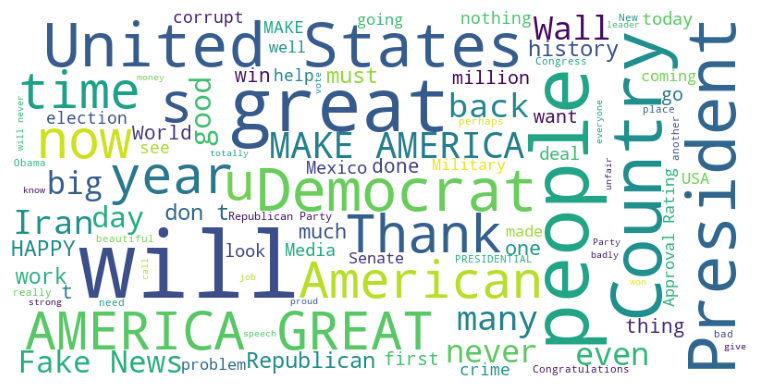

In [64]:
# WordCloud 생성
from wordcloud import WordCloud, STOPWORDS 
wordcloud = WordCloud(width = 800, height = 400, 
                      background_color ='white', 
                      stopwords = set(STOPWORDS), 
                      max_words=100,
                      min_font_size = 10,
                      max_font_size = 100,
                     ).generate(cleaned_text) 
  
# WordCloud 출력                    
plt.figure(figsize = (8, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout() 
plt.show()

# [추가 과제 예시] 
1) 월별 트윗량 변화에 대해서 분석
2) seaborn 라이브러리의 시각화 함수를 활용하여 그래프 표현
3) nltk 라이브러리를 활용한 텍스트 정제 

In [69]:
df_cleaned

,date,content,retweets,favorites,year,month
0,2009-05-04 20:54:25,Be sure to tune in and watch Donald Trump on L...,500,868,2009,05
1,2009-05-05 03:00:10,Donald Trump will be appearing on The View tom...,33,273,2009,05
2,2009-05-08 15:38:08,Donald Trump reads Top Ten Financial Tips on L...,12,18,2009,05
3,2009-05-08 22:40:15,New Blog Post: Celebrity Apprentice Finale and...,11,24,2009,05
4,2009-05-12 16:07:28,"""My persona will never be that of a wallflower...",1399,1965,2009,05
...,...,...,...,...,...,...
41117,2020-01-19 19:24:52,I have never seen the Republican Party as Stro...,32620,213817,2020,01
41118,2020-01-19 22:12:20,Now Mini Mike Bloomberg is critical of Jack Wi...,36239,149571,2020,01
41119,2020-01-20 01:27:07,I was thrilled to be back in the Great State o...,16588,66944,2020,01
41120,2020-01-20 02:16:00,"“In the House, the President got less due proc...",20599,81921,2020,01
